# Initialize Colab Environment

**Note 1: Sometimes the colab notebook runtimes 'break' and you get runtime errors for no reason. In these cases, restart the runtime by clicking 'Runtime' -> 'Restart Runtime' and run everything in this section again.**

**Note 2: If you care about speed, make sure your colab runtime uses a GPU. Do this by selecting 'Runtime' -> 'Change Runtime Type' -> 'Hardware Accelerator' -> 'GPU' (the runtime will restart and you'll have to re-run this section).**

We're going to mount your Google Drive first, using the command below. Just follow the prompts.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, we're going to change the directory to your drive, and make a folder for the tutorial. If any of these steps has been done before, it will simply be skipped (and throw an error message, which you can ignore).

In [2]:
%cd ~
%cd /content/drive/My\ Drive/
%mkdir wgan-tutorial
%cd wgan-tutorial

#eventually put our replication repo here
#!git clone https://github.com/gsbDBI/ds-wgan/

/root
/content/drive/My Drive
mkdir: cannot create directory ‘wgan-tutorial’: File exists
/content/drive/My Drive/wgan-tutorial


Next, install the wgan package written for the project:

In [3]:
#!pip3 uninstall wgan
#!pip3 install git+https://github.com/gsbDBI/ds-wgan.git@package#egg=wgan
!pip install git+https://github.com/gsbDBI/ds-wgan

  Cloning https://github.com/gsbDBI/ds-wgan to /tmp/pip-req-build-3neyczje
  Running command git clone --filter=blob:none --quiet https://github.com/gsbDBI/ds-wgan /tmp/pip-req-build-3neyczje
  Resolved https://github.com/gsbDBI/ds-wgan to commit ee7fa679dfda852cdb04cef211f2370599e657b6
  Preparing metadata (setup.py) ... done


# Simulating Data

The workflow for every single distribution you want to fit:

0.   Load and prepare the data
1.   Initialize a `wgan.DataWrapper` object, which takes care of handling the data
2.   Initialize `wgan.Specifications` object given the `DataWrapper`, which summarizes hyperparameters, etc.
3.   Initialize `wgan.Generator` & `wgan.Critic` given the `Specifications`
4.   Preprocess the data with the `DataWrapper` object
5.   Train the `Generator` & `Critic` via `wgan.train`
6.   Replace columns in df with simulated data from `Generator` using `DataWrapper.apply_generator`
7.   If you're interested in them, add the `Critic` outputs to the original and/or the generated df via `DataWrapper.apply_critic`
7.   Explore the data via `compare_dfs` & save the new data.

Since **we're fitting two distributions** (Y on X and t, as well as X on t), we'll have to do all these steps twice.
To keep the code concise, we will put the two versions of every obejct type into one list respectively. Watch out so you **don't get confused by that**!


## Steps 0-3

First load a data file from our project repo

In [79]:
import pandas as pd
import wgan
import io
import requests

In [80]:
df = pd.read_csv('JTPA_earn_synthetic_train_elder.csv')
df = df[["youth", "age", "hsged", "white", "black", "hispanic", "native", "asian", "children",	"married", "male", "treatment", "total_earn"]]

# df = pd.read_csv('JTPA_earn_full.csv')
# df = df[["age", "hsged", "white", "black", "hispanic", "native", "asian", "children",	"married", "male", "treatment", "total_earn"]]

# df = pd.read_csv('JTPA_earn_train.csv')
# df = df[["elder", "age", "hsged", "white", "black", "hispanic", "native", "asian", "children",	"married", "male", "treatment", "total_earn"]]

df.head()

,youth,age,hsged,white,black,hispanic,native,asian,children,married,male,treatment,total_earn
0,0,26.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000
1,0,31.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.000
2,0,36.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,54544.523
3,0,30.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,47684.047
4,0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.000


In [81]:
df.shape

(50000, 13)

In [82]:
# only run this is it's the synthetic dataset
# df_balanced = df.sample(2*len(df), weights=(1-df.t.mean())*df.t+df.t.mean()*(1-df.t), replace=True) # balanced df for training
df_balanced = df.sample(2*len(df), weights=(1-df.youth.mean())*df.youth+df.youth.mean()*(1-df.youth), replace=True) # balanced protected var df for training
# df_balanced = df.sample(2*len(df), weights=(1-df.elder.mean())*df.elder+df.elder.mean()*(1-df.elder), replace=True) # balanced protected var df for training

df_balanced = df_balanced[["age", "hsged", "white", "black", "hispanic", "native", "asian", "children",	"married", "male", "treatment", "total_earn"]]
df_balanced = df_balanced.sample(frac=0.5)
# Reset the index if needed
df_balanced.reset_index(drop=True, inplace=True)

After loading in our data as `df`, we will build from it second dataframe called `df_balanced`, by sampling treated and controls with similar probability from `df`. We will train our WGAN on `df_balanced`, which makes sure the quality of the generated outcomes is similar for both treatment groups.



In [83]:
# df_balanced = df
# original tutorial uses categorical as is. So it's possible the generator generates black = 1 and hispanic = 1

# X | t
continuous_vars_0 = ['age']
continuous_lower_bounds_0 = {"age": 16}
categorical_vars_0 = ["hsged", "white", "black", "hispanic", "native", "asian", "children", "married", "male"]
context_vars_0 = ["treatment"]

# Y | X, t
continuous_vars_1 = ["total_earn"]
continuous_lower_bounds_1 = {"total_earn": 0}
categorical_vars_1 = []
context_vars_1 = ["treatment", 'age', "hsged", "white", "black", "hispanic", "native", "asian", "children", "married", "male"]

# Initialize objects
data_wrappers = [wgan.DataWrapper(df_balanced, continuous_vars_0, categorical_vars_0,
                                  context_vars_0, continuous_lower_bounds_0),
                 wgan.DataWrapper(df_balanced, continuous_vars_1, categorical_vars_1,
                                  context_vars_1, continuous_lower_bounds_1)]
specs = [wgan.Specifications(dw, batch_size=2048, max_epochs=1000, critic_lr=1e-3, generator_lr=1e-3,
                             print_every=100, device = "cuda") for dw in data_wrappers]
generators = [wgan.Generator(spec) for spec in specs]
critics = [wgan.Critic(spec) for spec in specs]

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 19, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 1, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}


## Steps 4 & 5

Next, we train the model. How long this will take depends on the batch_size, the size of your data set and the max_epochs you specified.

You can also abort at any time, the model will keep its parameters at their most recent values during training. You can also resume the training, but this resets the optimizer state which basically means you might as well repeat at Step 3.

In [84]:
# train X | t
x, context = data_wrappers[0].preprocess(df_balanced)
wgan.train(generators[0], critics[0], x, context, specs[0])

epoch 0 | step 26 | WD_test 1.7 | WD_train 0.81 | sec passed 1 |
epoch 100 | step 2526 | WD_test 1.81 | WD_train 1.41 | sec passed 63 |
epoch 200 | step 5026 | WD_test 0.05 | WD_train 0.16 | sec passed 63 |
epoch 300 | step 7526 | WD_test 0.56 | WD_train 0.18 | sec passed 63 |
epoch 400 | step 10026 | WD_test 0.24 | WD_train 0.33 | sec passed 63 |
epoch 500 | step 12526 | WD_test 0.04 | WD_train 0.24 | sec passed 63 |
epoch 600 | step 15026 | WD_test 0.22 | WD_train 0.17 | sec passed 63 |
epoch 700 | step 17526 | WD_test 1.02 | WD_train 0.28 | sec passed 64 |
epoch 800 | step 20026 | WD_test -0.18 | WD_train 0.19 | sec passed 64 |
epoch 900 | step 22526 | WD_test -0.33 | WD_train 0.24 | sec passed 63 |


In [85]:
# train Y | X, t
x, context = data_wrappers[1].preprocess(df_balanced)
wgan.train(generators[1], critics[1], x, context, specs[1])

epoch 0 | step 26 | WD_test 0.45 | WD_train 0.19 | sec passed 1 |
epoch 100 | step 2526 | WD_test 0.21 | WD_train 0.17 | sec passed 62 |
epoch 200 | step 5026 | WD_test 0.11 | WD_train 0.15 | sec passed 62 |
epoch 300 | step 7526 | WD_test -0.54 | WD_train 0.16 | sec passed 63 |
epoch 400 | step 10026 | WD_test -0.13 | WD_train 0.19 | sec passed 63 |
epoch 500 | step 12526 | WD_test 0.15 | WD_train -0.01 | sec passed 63 |
epoch 600 | step 15026 | WD_test -0.17 | WD_train -0.06 | sec passed 64 |
epoch 700 | step 17526 | WD_test 0.07 | WD_train -0.06 | sec passed 64 |
epoch 800 | step 20026 | WD_test -0.04 | WD_train 0.12 | sec passed 64 |
epoch 900 | step 22526 | WD_test 0.32 | WD_train -0.01 | sec passed 64 |


## Steps 6 & 8

In [86]:
# simulate data with conditional WGANs
df_generated = data_wrappers[0].apply_generator(generators[0], df.sample(int(1e6), replace=True))
df_generated = data_wrappers[1].apply_generator(generators[1], df_generated)


# add counterfactual outcomes
from copy import copy
df_generated_cf = copy(df_generated)
df_generated_cf["treatment"] = 1 - df_generated_cf["treatment"]
df_generated["y_cf"] = data_wrappers[1].apply_generator(generators[1], df_generated_cf)["total_earn"]

# save to .feather
#df_generated.to_feather("data/generated/{}_generated.feather".format(name))

In [71]:
# df_generated.to_csv('JTPA_earn_synthetic_elder_generated.csv', index = False)
df_generated.to_csv('JTPA_earn_elder_generated.csv', index = False)

In [87]:
df_generated.shape

(1000000, 14)

In [88]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data as D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

def compare_dfs(df_real, df_fake, scatterplot=dict(x=[], y=[], samples=400, smooth=0),
                table_groupby=[], histogram=dict(variables=[], nrow=1, ncol=1),
                figsize=3,save=False,path=""):
    """
    Diagnostic function for comparing real and generated data from WGAN models.
    Prints out comparison of means, comparisons of standard deviations, and histograms
    and scatterplots.

    Parameters
    ----------
    df_real: pandas.DataFrame
        real data
    df_fake: pandas.DataFrame
        data produced by generator
    scatterplot: dict
        Contains specifications for plotting scatterplots of variables in real and fake data
    table_groupby: list
        List of variables to group mean and standard deviation table by
    histogram: dict
        Contains specifications for plotting histograms comparing marginal densities
        of real and fake data
    save: bool
        Indicate whether to save results to file or print them
    path: string
        Path to save diagnostics for model
    """
    # data prep
    if "source" in list(df_real.columns): df_real = df_real.drop("source", axis=1)
    if "source" in list(df_fake.columns): df_fake = df_fake.drop("source", axis=1)
    df_real.insert(0, "source", "real"), df_fake.insert(0, "source", "fake")
    common_cols = [c for c in df_real.columns if c in df_fake.columns]
    df_joined = pd.concat([df_real[common_cols], df_fake[common_cols]], axis=0, ignore_index=True)
    df_real, df_fake = df_real.drop("source", axis=1), df_fake.drop("source", axis=1)
    common_cols = [c for c in df_real.columns if c in df_fake.columns]
    print(common_cols)
    # mean and std table

    means = df_joined.groupby(table_groupby + ["source"]).mean().round(2).transpose()
    if save:
        means.to_csv(path+"_means.txt",sep=" ")
    else:
        print("-------------comparison of means-------------")
        print(means)

    stds = df_joined.groupby(table_groupby + ["source"]).std().round(2).transpose()

    if save:
        stds.to_csv(path+"_stds.txt",sep=" ")
    else:
        print("-------------comparison of stds-------------")
        print(stds)
    # covariance matrix comparison
    fig1 = plt.figure(figsize=(figsize * 2, figsize * 1))
    s1 = [fig1.add_subplot(1, 2, i) for i in range(1, 3)]
    s1[0].set_xlabel("real")
    s1[1].set_xlabel("fake")
    s1[0].matshow(df_real[common_cols].corr())
    s1[1].matshow(df_fake[common_cols].corr())
    # histogram marginals
    if histogram and len(histogram["variables"]) > 0:
        fig2, axarr2 = plt.subplots(histogram["nrow"], histogram["ncol"],
                                    figsize=(histogram["nrow"]*(figsize), histogram["ncol"]*(figsize)))
        v = 0
        for i in range(histogram["nrow"]):
            for j in range(histogram["ncol"]):
                plot_var, v = histogram["variables"][v], v+1
                # axarr2[i][j].hist([df_real[plot_var], df_fake[plot_var]], bins=8, density=1,
                                  #  histtype='bar', label=["real", "fake"], color=["blue", "red"])
                print()
                axarr2[i][j].hist([df_real[plot_var], df_fake[plot_var]], bins=8, weights=[np.ones_like(df_real[plot_var])/len(df_real[plot_var]), np.ones_like(df_fake[plot_var])/len(df_fake[plot_var])],
                                  histtype='bar', label=["real", "fake"], color=["blue", "red"])
                axarr2[i][j].legend(prop={"size": 10})
                axarr2[i][j].set_title(plot_var)
        if save:
            fig2.savefig(path+'_hist.png')
        else:
            fig2.show()
    # scatterplot grid
    if scatterplot and len(scatterplot["x"]) * len(scatterplot["y"]) > 0:
        df_real_sample = df_real.sample(scatterplot["samples"])
        df_fake_sample = df_fake.sample(scatterplot["samples"])
        x_vars, y_vars = scatterplot["x"], scatterplot["y"]
        fig3 = plt.figure(figsize=(len(x_vars) * (figsize), len(y_vars) * figsize))
        s3 = [fig3.add_subplot(len(y_vars), len(x_vars), i + 1) for i in range(len(x_vars) * len(y_vars))]
        count = 0
        for y in y_vars:
            for x in x_vars:
                s = s3.pop(0)
                x_real, y_real = df_real_sample[x].to_numpy(),  df_real_sample[y].to_numpy()
                x_fake, y_fake = df_fake_sample[x].to_numpy(), df_fake_sample[y].to_numpy()
                from math import sqrt,pi
                def fit(xx, yy):
                    xx, yy = torch.tensor(xx).to(torch.float), torch.tensor(yy).to(torch.float)
                    xx = (xx - xx.mean())/ xx.std()
                    bw = 1e-9 + scatterplot["smooth"] # * (xx.max()-xx.min())
                    dist = (xx.unsqueeze(0) - xx.unsqueeze(1)).pow(2)/bw
                    kern = 1/sqrt(2*pi)*torch.exp(-dist**2/2)
                    w = kern / kern.sum(1, keepdim=True)
                    y_hat = w.mm(yy.unsqueeze(1)).squeeze()
                    return y_hat.detach().numpy()
                y_real, y_fake = fit(x_real, y_real), fit(x_fake, y_fake)
                s.scatter(x_real, y_real, color="blue")
                s.scatter(x_fake, y_fake, color="red")
                if count == 0:
                  s.set_ylabel(y)
                s.set_xlabel(x)
                count+=1

        if save:
            fig3.savefig(path+'_scatter.png')
        else:
            fig3.show()

att: 176.34756970761018
['age', 'hsged', 'white', 'black', 'hispanic', 'native', 'asian', 'children', 'married', 'male', 'treatment', 'total_earn']
-------------comparison of means-------------
treatment          0                   1          
source          fake      real      fake      real
age            38.24     35.69     38.48     35.67
hsged           0.45      0.47      0.45      0.46
white           0.72      0.73      0.72      0.72
black           0.21      0.21      0.20      0.20
hispanic        0.00      0.04      0.00      0.04
native          0.00      0.00      0.00      0.00
asian           0.01      0.01      0.02      0.01
children        0.44      0.44      0.44      0.44
married         0.32      0.31      0.34      0.33
male            0.43      0.43      0.43      0.44
total_earn  13439.45  13059.54  13651.14  13420.72
-------------comparison of stds-------------
treatment          0                   1          
source          fake      real      fake      r

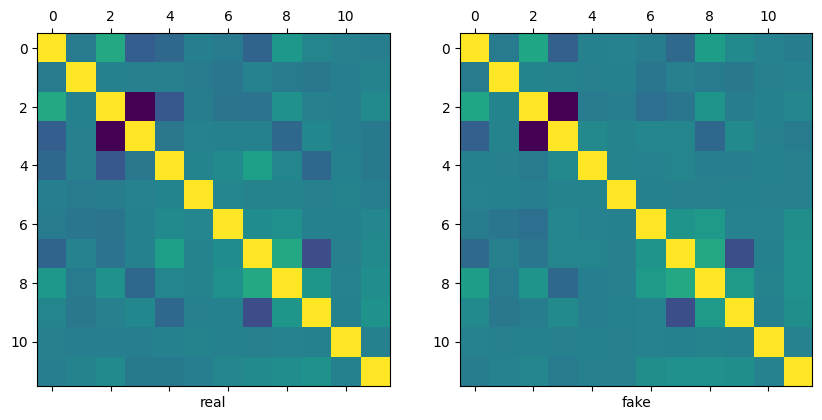

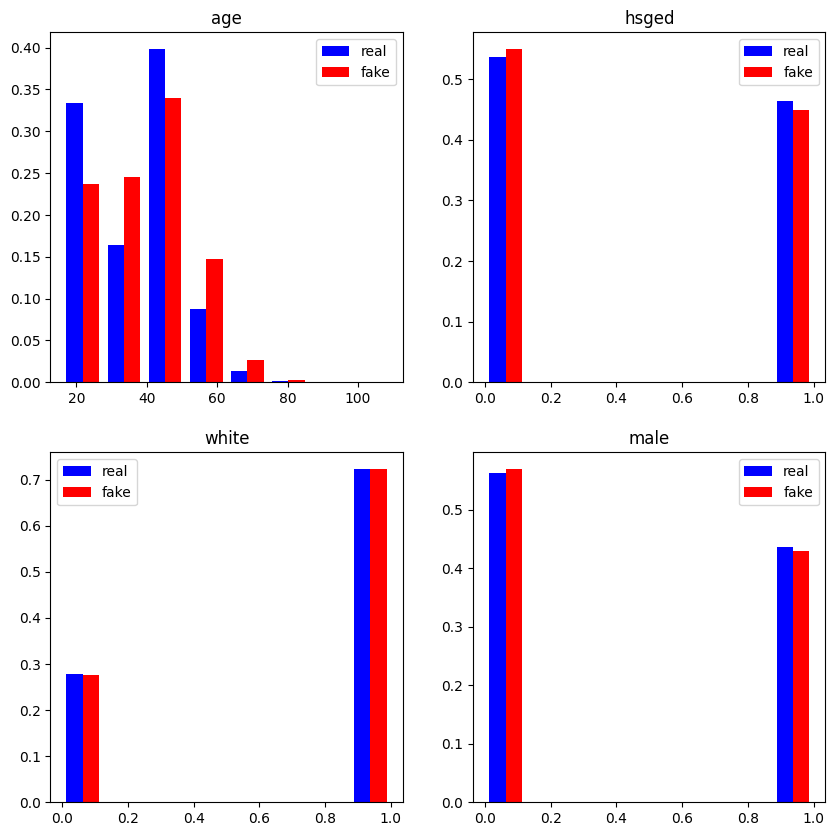

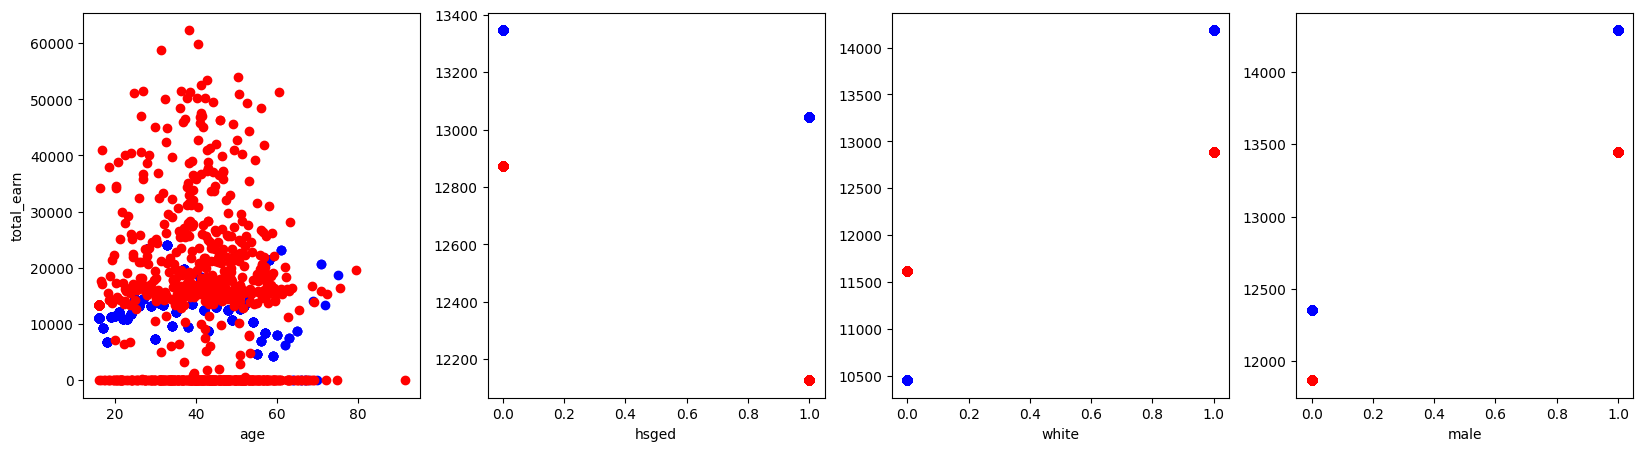

In [89]:
print("att:", ((df_generated.total_earn-df_generated.y_cf) * (2*df_generated.treatment - 1))[df_generated.treatment==1].mean())
# df["total_earn"] /= 1000
# df_generated["total_earn"] /= 1000
compare_dfs(df_balanced, df_generated,
                 scatterplot=dict(x=['age', "hsged", "white", "male"], y=["total_earn"], samples=1000, smooth=0),
                 table_groupby=["treatment"],
                 histogram=dict(variables=['age', "hsged", "white", "male"], nrow=2, ncol=2),
                 figsize=5)